## Imports

In [111]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

from copy import deepcopy

from math import pi, cos, sin, sqrt, tan, acos
import numpy as np
from numpy import array, zeros, arange
from numpy import concatenate as np_concat
from numpy import real
from numpy.linalg import eig as eigenvalues
import matplotlib.pyplot as plt

from calculate_system import EquationCalculator
from progress_bar import ProgressBar
from create_fig import *
from function_root_finder import roots



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [4]:
M = 2.0
c1 = 1000.0
c0 = 1.0 * c1

beta = 0.1

r = 0.04
I = 2.0

b = 0.5  # engine
d = 0.01

# 3 DOF additions

m = M * 0.3

L = 1.2
gamma = pi / 6

beta1 = beta * 1.0
beta2 = beta * 0.5

c2 = c1 * 0.3
c3 = c1 * 0.3

# dimensionless max engine rotation velocity. 1 = resonance
engine_om_max = 2.5

In [5]:
def recalculate_supplementary_parameters(print_parameters=True, new_eps=0.1):
    global om_l, k, om, Lcos, k0, engine_om_max, a, OM_max, K_L, q, eps, K_, h1, \
           h, r_, mu, k2, k3, r_eps, h2, ro, Aw, Aw2, r_eps2, k2_, k3_, kw, kw_, ro_
        
    om_l = sqrt(c1 / M)
    k = c0 / c1
    om = sqrt(1 + k)

    Lcos = L * cos(gamma)
    k0 = k

    #

    engine_om_max_ = om * engine_om_max
    a = engine_om_max_ * (b - d) * om_l

    OM_max = a / b
    K_L = a / OM_max
    q = OM_max / om_l

    if print_parameters:
        print("om_l   = ", om_l)
        print("k      = ", k)
        print("om     = ", om)
        print("K_L    = ", K_L)
        print("OM_max = ", OM_max)
        print("q      = ", q)
        print("")

    eps = new_eps

    K_ = K_L / om_l / I / eps
    h1 = d / om_l / I / eps
    h = beta1 / om_l / M / eps
    r_ = r / eps

    mu = m / M / eps
    k2 = c2 / c1 / eps
    k3 = c3 / c1 / eps
    r_eps = r / Lcos / eps
    h2 = beta2 / M / om_l / eps**2

    ro = r_eps * M / I * Lcos**2

    if print_parameters:
        print("eps    = ", eps)
        print("K_L    = ", K_L)
        print("h      = ", h)
        print("h1     = ", h1)
        print("r_     = ", r_)

    Aw = (2.0 - 2.0 * cos(gamma)) ** 0.5 / eps
    Aw2 = Aw ** 2
    r_eps2 = r_eps / eps

    k2_ = k2 / cos(gamma)
    k3_ = k3 / cos(gamma)
    kw = (k2 + k3) * (1 - 1 / cos(gamma))  # kw + (k2+k3) / cos(gamma) * 1.5 * Aw2 * eps #
    kw_ = 2 * (k2 + k3) * (1 / cos(gamma) - 1)
    ro_ = ro * eps

    print("recalculate, engine om max = %f", engine_om_max_)

    if print_parameters:
        print("Aw     = ", Aw)

In [6]:
recalculate_supplementary_parameters(print_parameters=True, new_eps=0.1)

om_l   =  22.360679774997898
k      =  1.0
om     =  1.4142135623730951
K_L    =  0.5
OM_max =  77.4758026741253
q      =  3.464823227814083

eps    =  0.1
K_L    =  0.5
h      =  0.022360679774997897
h1     =  0.0022360679774997894
r_     =  0.39999999999999997
recalculate, engine om max = %f 3.5355339059327378
Aw     =  5.176380902050413


## Equations

2 Dof system equation

In [8]:
def initial_2_DOF(t, v):
    """
    F[0] = x
    F[1] = x'
    F[2] = fi
    F[3] = fi'
    """
    F = zeros(4)
    F[0] = v[1]
    F[1] = (-c1*(v[0]-r*sin(v[2])) - c0*v[0] - beta*v[1]) / M
    F[2] = v[3]
    F[3] = (K_L * (OM_max - v[3]) - d*v[3] + c1*r * (v[0] - r*sin(v[2])) * cos(v[2])) / I
    return F

2 Dof system with inclusion of small parameter

In [9]:
def initial_2_DOF_with_eps(t, v):
    """
    v[0] = x
    v[1] = x'
    v[2] = fi
    v[3] = fi'
    """
    F = zeros(4)
    F[0] = v[1]
    F[1] = -(om**2)*v[0] + eps * (r_*sin(v[2]) - h*v[1])
    F[2] = v[3]
    F[3] = eps * (K_ * (q - v[3]) - h1*v[3] + r_ * v[0] * cos(v[2]) * M/I) - (eps**2) * (r_**2 * 0.5 * sin(2.0 * v[2]) * M/I)
    return F

## 2 Dof system check

In [10]:
initial_eq = EquationCalculator(initial_2_DOF, [0, 0, 0, 0], method='rk5a', ignore_cache=True)
initial_eq.step_size /= om_l
initial_eq.caclulate()


[= Runge Kutta 5 Adaptive ========================]
[=================================================]


In [11]:
initial_eps = EquationCalculator(initial_2_DOF_with_eps, [0, 0, 0, 0], method='rk5a', ignore_cache=True, time_scale=om_l)
initial_eps.caclulate()


[= Runge Kutta 5 Adaptive ========================]
[=================================================]


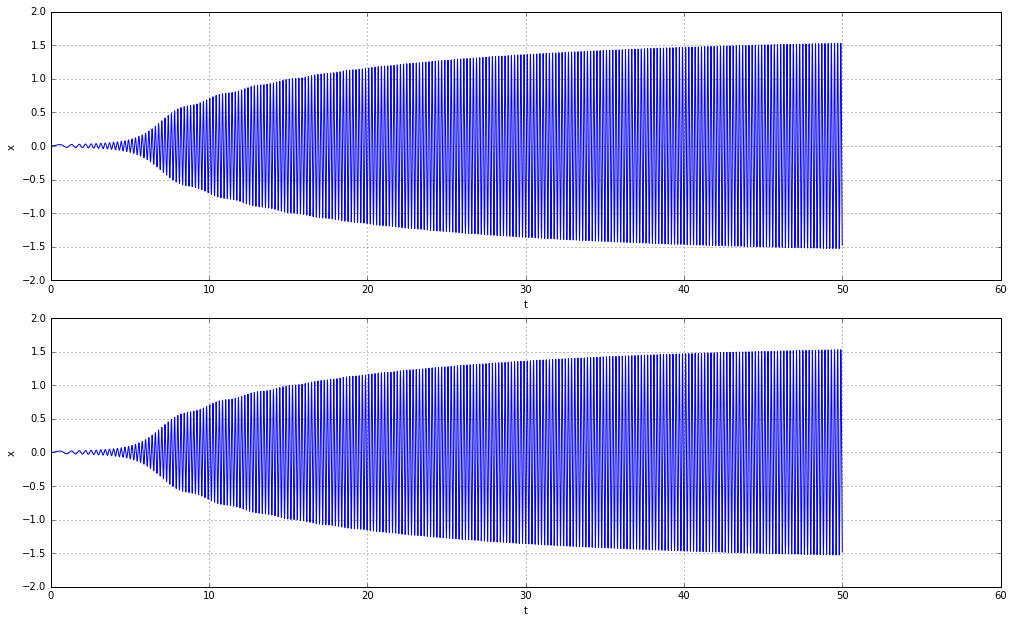

In [12]:
%matplotlib inline

fig = create_fig()
plots = add_subplots(fig, 2)

initial_eq.plot(plots[0], 't', '.t', 'x', '.v0', 'b-')
initial_eps.plot(plots[1], 't', '.t', 'x', '.v0', 'b-')

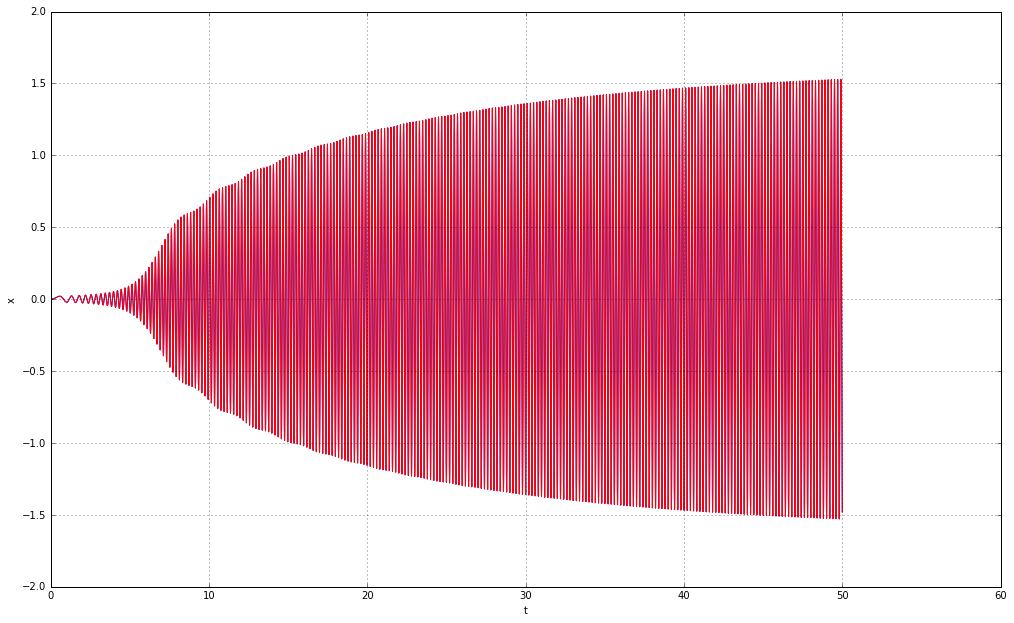

In [27]:
%matplotlib inline

fig = create_fig()
plots = add_subplots(fig, 1)

initial_eq.plot(plots[0], 't', '.t', 'x', '.v0', 'b-')
initial_eps.plot(plots[0], 't', '.t', 'x', '.v0', 'r-')

## 3DOF sysem stability and verification

In [112]:
# stability parameters
# p0 = K_*q / (K_ + h1)
# p0 = om * 2.5
p0
a0 = p0 * h2/mu/2.0
D = k2_/8.0/mu * Aw * r_eps / (p0**2 - om**2)
D12 = (D / a0)**2

delta = 0
k_a = 3 * (k2_+k3_) / 4.0 / mu

In [113]:
# satbility function
def f(n):
    return ((k_a*D12)**2 * (n**3)
            + delta*k_a*D12 * (n**2)
            + (0.25*delta**2 + a0**2) * n
            - a0**2)

In [114]:
STABLE = 0
UNSTABLE = 1
UNKNOWN = 2

unknown_barier = 0.0001
t0 = -1000000.0

def stability(a0, b0):
    K05 = 0.5 * (K_ + h1)
    m00 = 0
    m01 = 0
    m02 = -K05 * p0
    m10 = -p0 * h2/mu/2.0
    m11 = -D * sin(b0)
    m12 = a0 * (K05 - h2/mu/2.0)
    m20 = delta/2.0/a0 + 3*k_a*a0
    m21 = -D/a0 * cos(b0)
    m22 = p0 * t0 * K05
    matrix = array([[m00, m01, m02], [m10, m11, m12], [m20, m21, m22]])

    w, v = eigenvalues(matrix)
#     print(w)
    if all([abs(real(l)) < unknown_barier for l in w]):
#         print("UNKNOWN")
        return UNKNOWN
    elif all([real(l) < 0 for l in w]):
#         print("STABLE")
        return STABLE
    else:
#         print("UNSTABLE")
        return UNSTABLE

In [115]:
#preparation

xs, ys = [[], [], []], [[], [], []]
max_y = 0
deltas = np_concat(
    (arange(-1.0, 3, 0.01), arange(0.0, 1.0, 0.005), arange(0.36, 0.4, 0.0001))
#     (arange(-10.0, 30, 0.1), arange(0.0, 1.0, 0.005), arange(0.36, 0.4, 0.0001))
)

# calculate stability

pb = ProgressBar("Stability points", 0, len(deltas) - 1)
pb_counter = 0
for i in deltas:
    pb.setValue(pb_counter)
    pb_counter += 1

    delta = -i
    ns = roots(f, 0.0, 1.0, eps=1e-3)

    for n in ns:
        b = acos(n ** 0.5)
        a = (n ** 0.5) * (D / a0)
        st = stability(a, b)

        ys[st].append(a)
        xs[st].append(i)
        
        if max_y < a:
            max_y = a    



[= Stability points ==============================]
[=================================================]


In [116]:
# calculate field (optional)
field_x = arange(-1.0, 3.0, 0.025)
field_y = arange(0.01, max_y + 0.01, 0.01)
pb = ProgressBar("Stability field", 0, len(field_x) - 1)
pb_counter = 0

xs2 = deepcopy(xs)
ys2 = deepcopy(ys)

for i in field_x:
    pb.setValue(pb_counter)
    pb_counter += 1
    for j in field_y:
        if j > max_y:
            xs2[UNKNOWN].append(i)
            ys2[UNKNOWN].append(j)
            continue

        delta = -i
        a = j
        b = acos(a / D * a0)
        st = stability(a, b)
        xs2[st].append(i)
        ys2[st].append(j)


[= Stability field ===============================]
[=================================================]


<IPython.core.display.Javascript object>


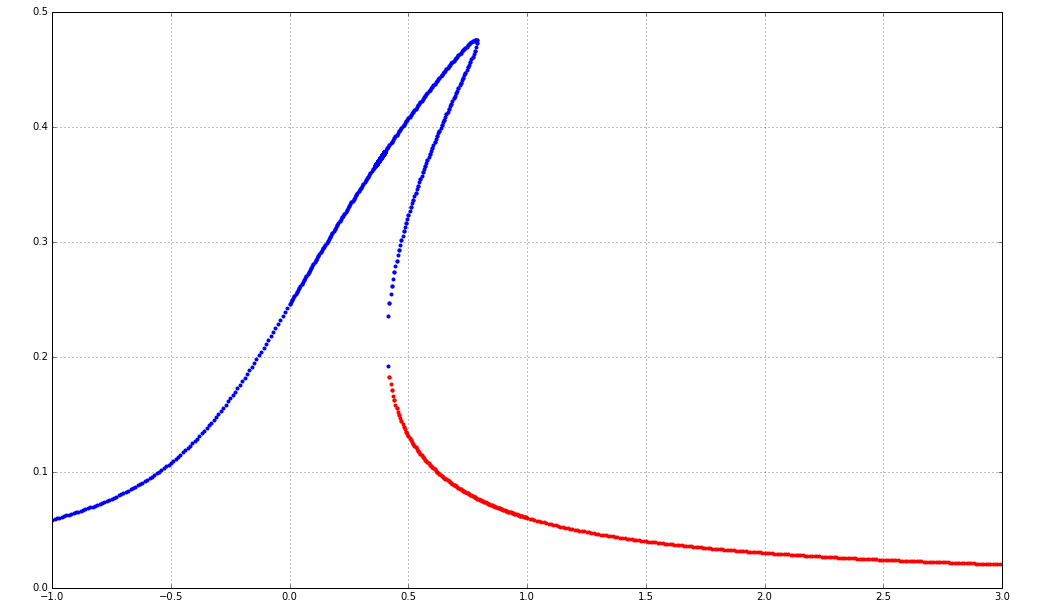

In [137]:
%matplotlib notebook

fig = create_fig()
plt.grid(b=True)

plt.plot(xs[STABLE], ys[STABLE], "bo", markeredgewidth=0.0, markersize=4)
plt.plot(xs[UNSTABLE], ys[UNSTABLE], "ro", markeredgewidth=0.0, markersize=4)
plt.plot(xs[UNKNOWN], ys[UNKNOWN], "go", markeredgewidth=0.0, markersize=4)

<IPython.core.display.Javascript object>


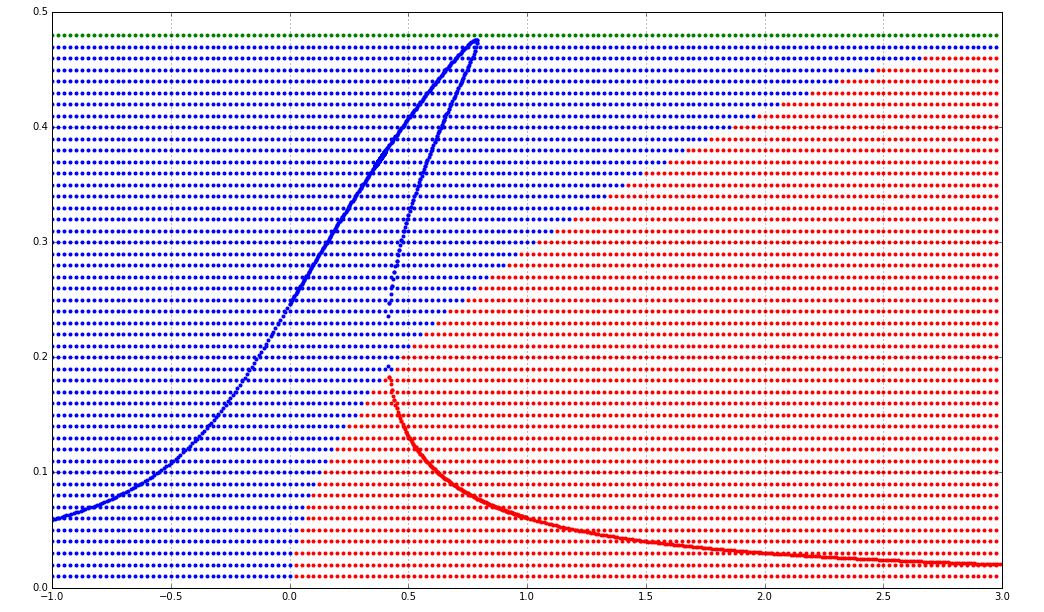

In [138]:
%matplotlib notebook

fig = create_fig()
plt.grid(b=True)

plt.plot(xs2[STABLE], ys2[STABLE], "bo", markeredgewidth=0.0, markersize=4)
plt.plot(xs2[UNSTABLE], ys2[UNSTABLE], "ro", markeredgewidth=0.0, markersize=4)
plt.plot(xs2[UNKNOWN], ys2[UNKNOWN], "go", markeredgewidth=0.0, markersize=4)

In [119]:
print(a0)
print(D)
print("Stable")
for i in range(len(xs[STABLE])):
    _d = xs[STABLE][i]
    _a = ys[STABLE][i]
    _b = acos(_a * a0 / D) 
    print ("delta: %f,\ta: %f,\tb: %f" % (_d, _a, _b))

0.06329722440696511
0.030148003480231535
Stable
delta: -1.000000,	a: 0.059114,	b: 1.446362
delta: -0.990000,	a: 0.059681,	b: 1.445162
delta: -0.980000,	a: 0.060259,	b: 1.443940
delta: -0.970000,	a: 0.060847,	b: 1.442695
delta: -0.960000,	a: 0.061446,	b: 1.441426
delta: -0.950000,	a: 0.062057,	b: 1.440133
delta: -0.940000,	a: 0.062679,	b: 1.438815
delta: -0.930000,	a: 0.063314,	b: 1.437472
delta: -0.920000,	a: 0.063960,	b: 1.436102
delta: -0.910000,	a: 0.064620,	b: 1.434705
delta: -0.900000,	a: 0.065292,	b: 1.433280
delta: -0.890000,	a: 0.065977,	b: 1.431827
delta: -0.880000,	a: 0.066677,	b: 1.430344
delta: -0.870000,	a: 0.067390,	b: 1.428831
delta: -0.860000,	a: 0.068118,	b: 1.427288
delta: -0.850000,	a: 0.068860,	b: 1.425712
delta: -0.840000,	a: 0.069619,	b: 1.424103
delta: -0.830000,	a: 0.070392,	b: 1.422461
delta: -0.820000,	a: 0.071182,	b: 1.420784
delta: -0.810000,	a: 0.071989,	b: 1.419071
delta: -0.800000,	a: 0.072813,	b: 1.417321
delta: -0.790000,	a: 0.073654,	b: 1.415533
delta:

In [120]:
print("Unstable")
for i in range(len(xs[UNSTABLE])):
    _d = xs[UNSTABLE][i]
    _a = ys[UNSTABLE][i]
    _b = acos(_a * a0 / D) 
    print ("delta: %f,\ta: %f,\tb: %f" % (_d, _a, _b))

Unstable
delta: 0.420000,	a: 0.183302,	b: 1.175748
delta: 0.430000,	a: 0.171386,	b: 1.202707
delta: 0.440000,	a: 0.162702,	b: 1.222176
delta: 0.450000,	a: 0.155674,	b: 1.237833
delta: 0.460000,	a: 0.149699,	b: 1.251077
delta: 0.470000,	a: 0.144469,	b: 1.262621
delta: 0.480000,	a: 0.139803,	b: 1.272885
delta: 0.490000,	a: 0.135582,	b: 1.282144
delta: 0.500000,	a: 0.131723,	b: 1.290584
delta: 0.510000,	a: 0.128167,	b: 1.298345
delta: 0.520000,	a: 0.124868,	b: 1.305529
delta: 0.530000,	a: 0.121792,	b: 1.312217
delta: 0.540000,	a: 0.118909,	b: 1.318472
delta: 0.550000,	a: 0.116198,	b: 1.324345
delta: 0.560000,	a: 0.113640,	b: 1.329880
delta: 0.570000,	a: 0.111219,	b: 1.335111
delta: 0.580000,	a: 0.108922,	b: 1.340068
delta: 0.590000,	a: 0.106737,	b: 1.344777
delta: 0.600000,	a: 0.104655,	b: 1.349260
delta: 0.610000,	a: 0.102668,	b: 1.353535
delta: 0.620000,	a: 0.100767,	b: 1.357620
delta: 0.630000,	a: 0.098947,	b: 1.361529
delta: 0.640000,	a: 0.097200,	b: 1.365275
delta: 0.650000,	a: 0.095

<IPython.core.display.Javascript object>


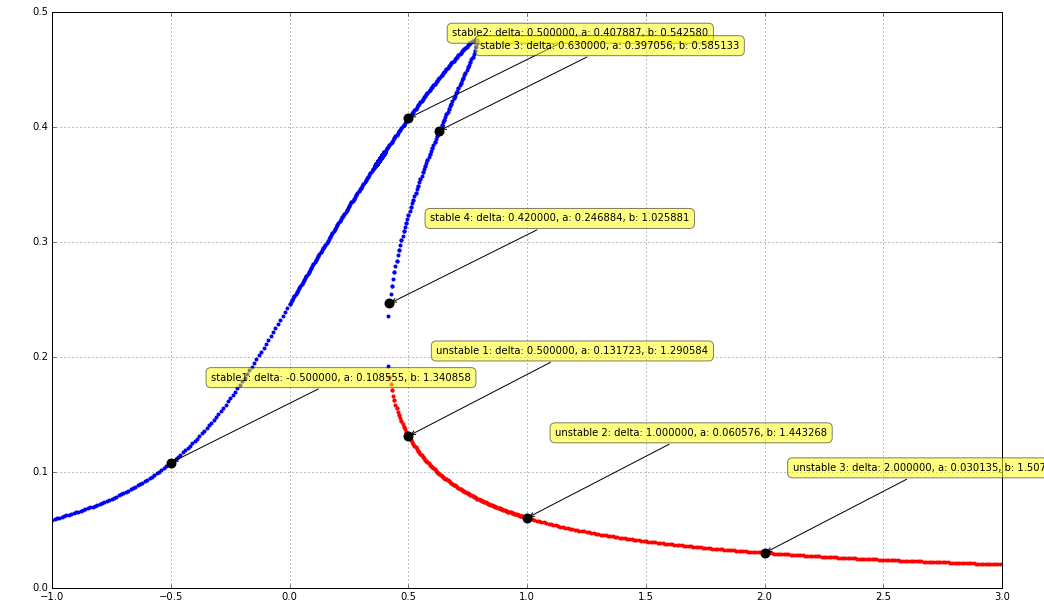

In [139]:
# display selected points

fig = create_fig()
plt.grid(b=True)

plt.plot(xs[STABLE], ys[STABLE], "bo", markeredgewidth=0.0, markersize=4)
plt.plot(xs[UNSTABLE], ys[UNSTABLE], "ro", markeredgewidth=0.0, markersize=4)
plt.plot(xs[UNKNOWN], ys[UNKNOWN], "go", markeredgewidth=0.0, markersize=4)

labels = [
 ["stable1: delta: -0.500000, a: 0.108555, b: 1.340858" , -0.5, 0.108555],
 ["stable2: delta: 0.500000, a: 0.407887, b: 0.542580", 0.5, 0.407887],
 ["stable 3: delta: 0.630000, a: 0.397056, b: 0.585133", 0.63,  0.397056],
 ["stable 4: delta: 0.420000, a: 0.246884, b: 1.025881", 0.42, 0.246884],
 ["unstable 1: delta: 0.500000, a: 0.131723, b: 1.290584", 0.5,  0.131723],
 ["unstable 2: delta: 1.000000, a: 0.060576, b: 1.443268", 1.0,  0.060576],
 ["unstable 3: delta: 2.000000, a: 0.030135, b: 1.507484", 2.0,  0.030135]
]

for label, x, y in labels:
    plt.annotate(
        label,
        xy=(x, y), xytext=(300, 80),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    plt.plot(x, y, "ko", markeredgewidth=0.0, markersize=10)

In [122]:
# a b equation
def ab(t, v):
    """
    F[0] = a
    f[1] = b
    """
    a = v[0]
    b = v[1]
    F = zeros(2)
    F[0] = -a * h2/2.0/mu + D/p0 * cos(b)
    F[1] = 1/p0 * (0.5 * delta - k_a*a**2 - D/a * sin(b))
    return F
    

In [123]:
def check_ab_stability(_del, _a, _b):
    global delta
    delta = _del

    ab_check1 = EquationCalculator(ab, [_a, _b], method='rk5a', ignore_cache=True, t_end=1000.0)
    ab_check1.caclulate()

    fig = create_fig()
    plots = add_subplots(fig, 2)
    ab_check1.plot(plots[0], "t", ".t", "a", ".v0", "b-")
    ab_check1.plot(plots[1], "t", ".t", "b", ".v1", "b-")


[= Runge Kutta 5 Adaptive ========================]
[=================================================]


<IPython.core.display.Javascript object>


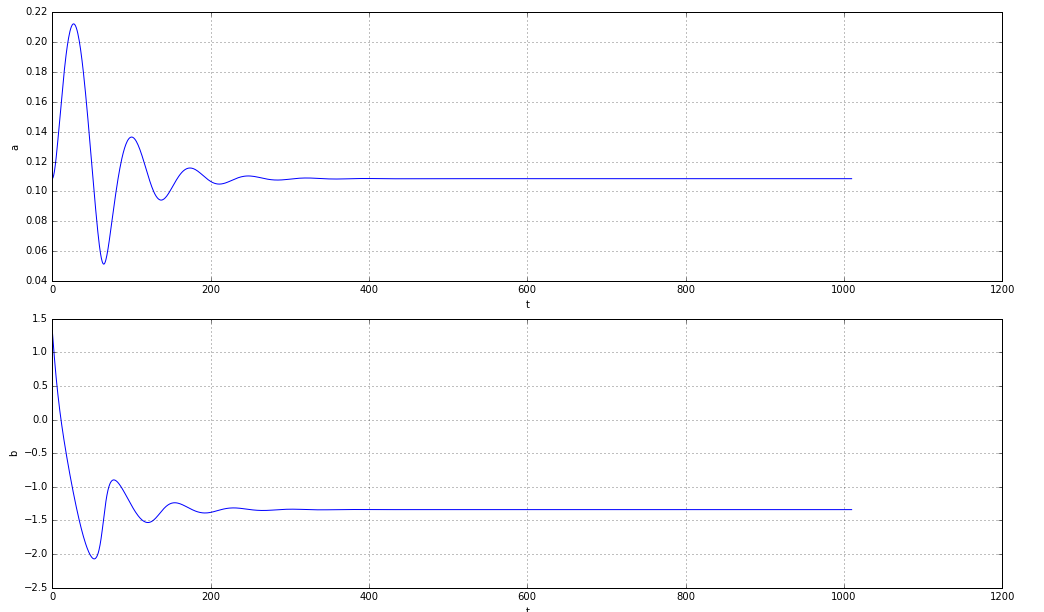

In [124]:
%matplotlib notebook

# stable 1
# delta: -0.500000,	a: 0.108555,	b: 1.340858

check_ab_stability(-0.5, 0.108555, 1.340858)


[= Runge Kutta 5 Adaptive ========================]
[================================================]


<IPython.core.display.Javascript object>


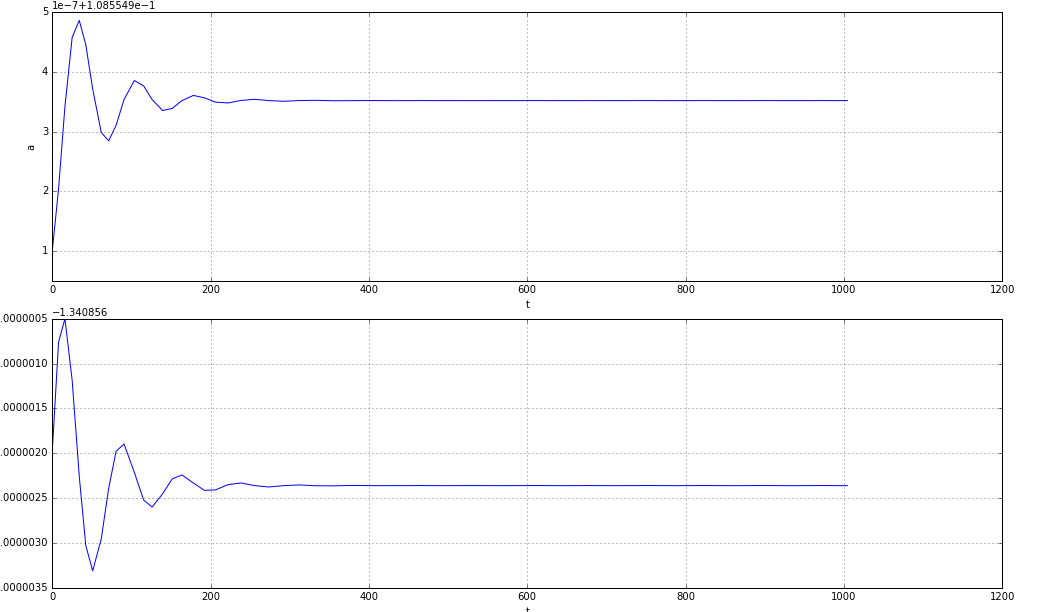

In [125]:
# stable 1 with negative b
# delta: -0.500000,	a: 0.108555,	b: 1.340858

check_ab_stability(-0.5, 0.108555, -1.340858)


[= Runge Kutta 5 Adaptive ========================]
[================================================]


<IPython.core.display.Javascript object>


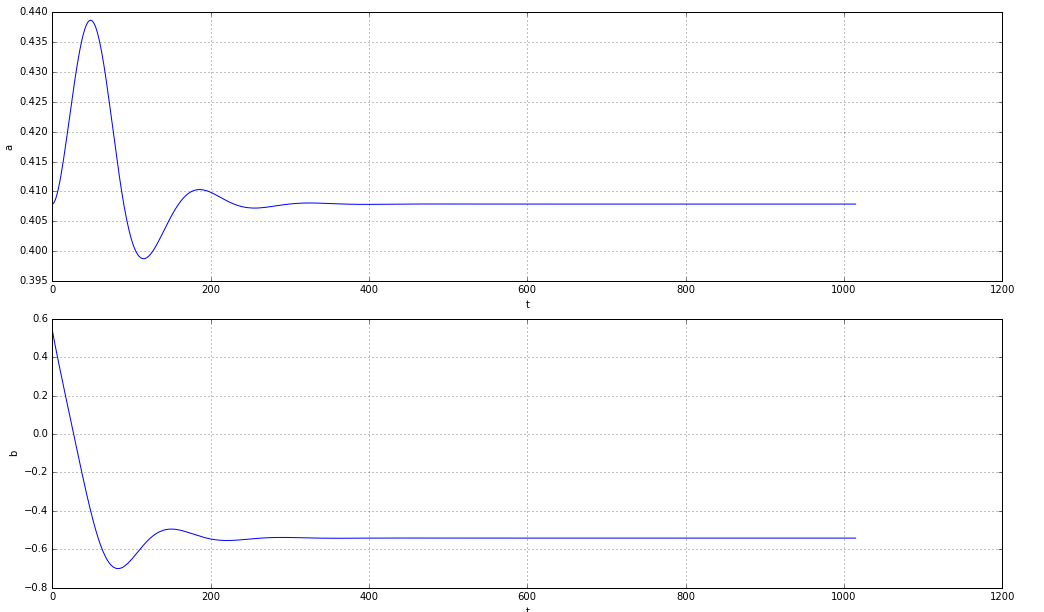

In [126]:
# stable 2

# delta: 0.500000,	a: 0.407887,	b: 0.542580

check_ab_stability(0.5, 0.407887, 0.542580)


[= Runge Kutta 5 Adaptive ========================]
[===============================================]


<IPython.core.display.Javascript object>


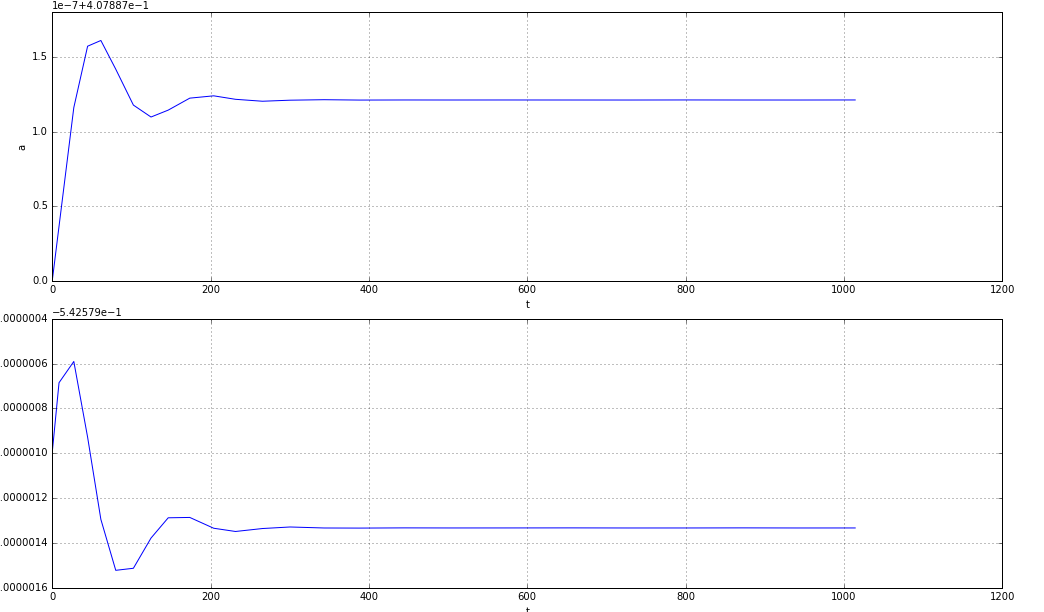

In [127]:
# stable 2 with negative b

# delta: 0.500000,	a: 0.407887,	b: 0.542580

check_ab_stability(0.5, 0.407887, -0.542580)


[= Runge Kutta 5 Adaptive ========================]
[=================================================]


<IPython.core.display.Javascript object>


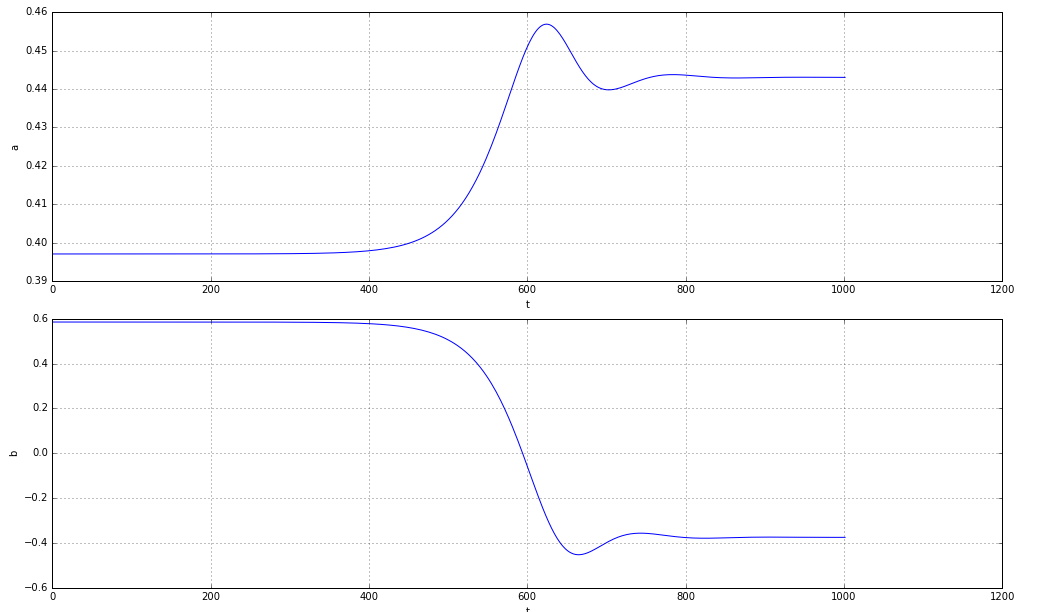

In [128]:
# stable 3: delta: 0.630000, a: 0.397056, b: 0.585133
check_ab_stability(0.630000, 0.397056, 0.585133)


[= Runge Kutta 5 Adaptive ========================]
[===================================================

<IPython.core.display.Javascript object>


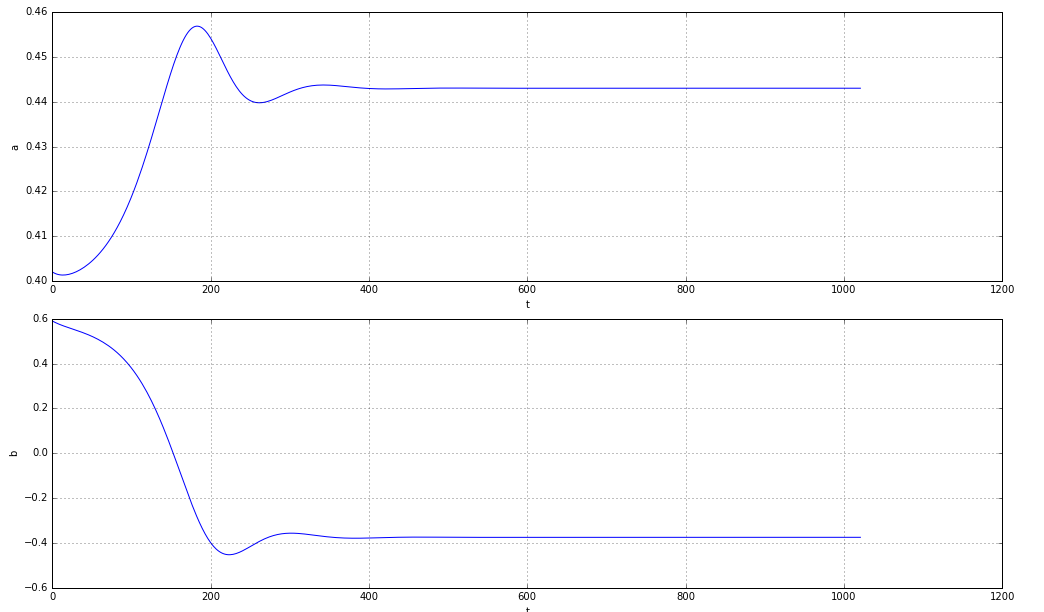

In [129]:
# stable 3: delta: 0.630000, a: 0.397056, b: 0.585133 (with disturbance)
check_ab_stability(0.630000, 0.397056 + 0.005, 0.585133 + 0.005)


[= Runge Kutta 5 Adaptive ========================]
[=================================================]


<IPython.core.display.Javascript object>


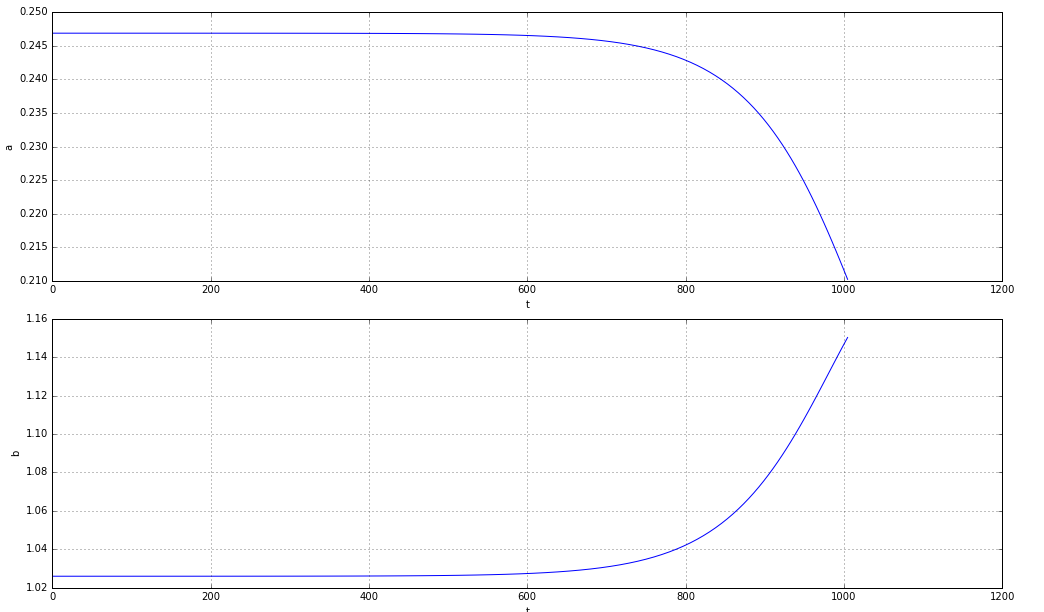

In [130]:
# stable 4: delta: 0.420000, a: 0.246884, b: 1.025881
check_ab_stability(0.420000, 0.246884, 1.025881)


[= Runge Kutta 5 Adaptive ========================]
[===================================================

<IPython.core.display.Javascript object>


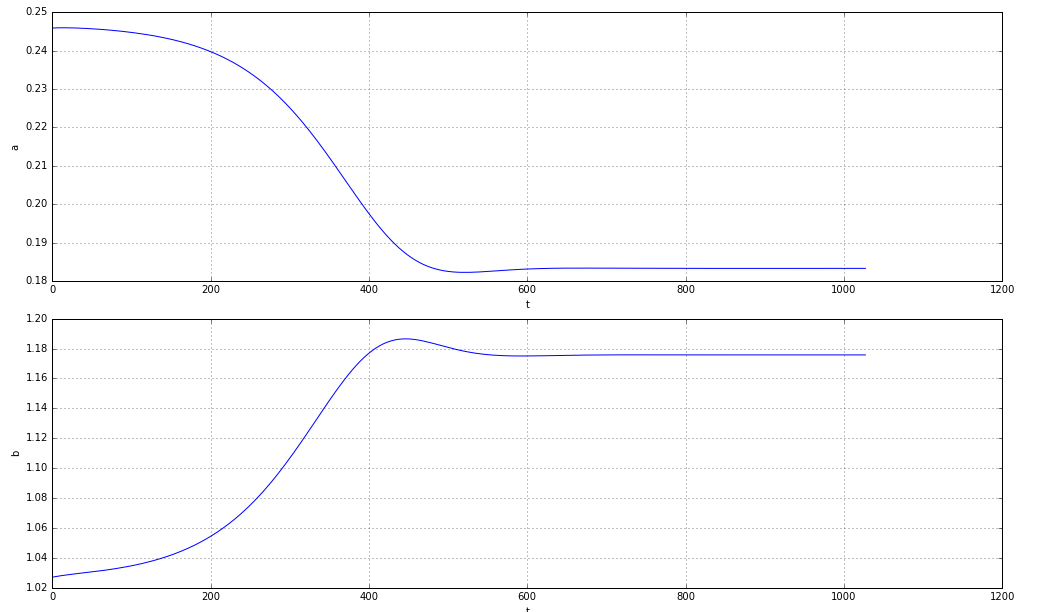

In [131]:
# stable 4: delta: 0.420000, a: 0.246884, b: 1.025881 (with disturbance)
check_ab_stability(0.420000, 0.246884 - 0.001, 1.025881 + 0.001)


[= Runge Kutta 5 Adaptive ========================]
[=================================================]


<IPython.core.display.Javascript object>


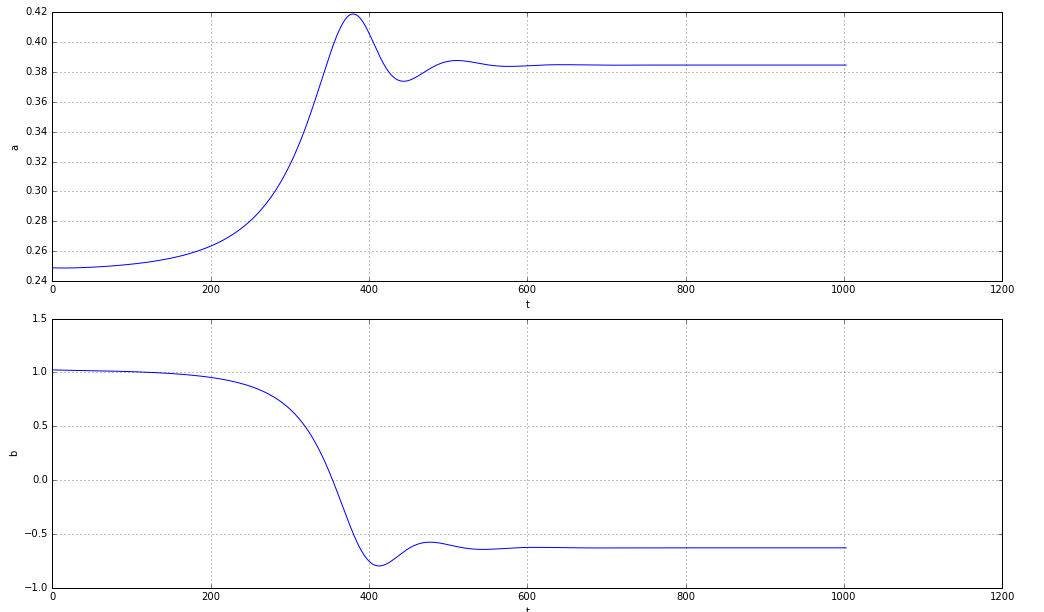

In [132]:
# stable 4: delta: 0.420000, a: 0.246884, b: 1.025881 (with disturbance 2)
check_ab_stability(0.420000, 0.246884 + 0.002, 1.025881 - 0.002)


[= Runge Kutta 5 Adaptive ========================]
[===============================================]


<IPython.core.display.Javascript object>


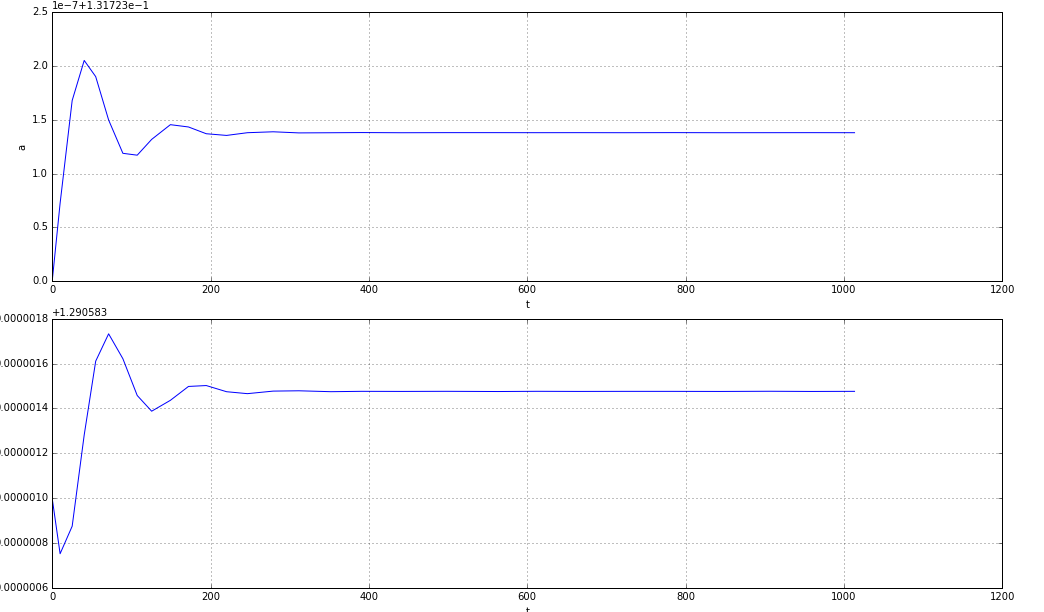

In [133]:
# unstable 1: delta: 0.500000, a: 0.131723, b: 1.290584
check_ab_stability(0.500000, 0.131723, 1.290584)


[= Runge Kutta 5 Adaptive ========================]
[=================================================]


<IPython.core.display.Javascript object>


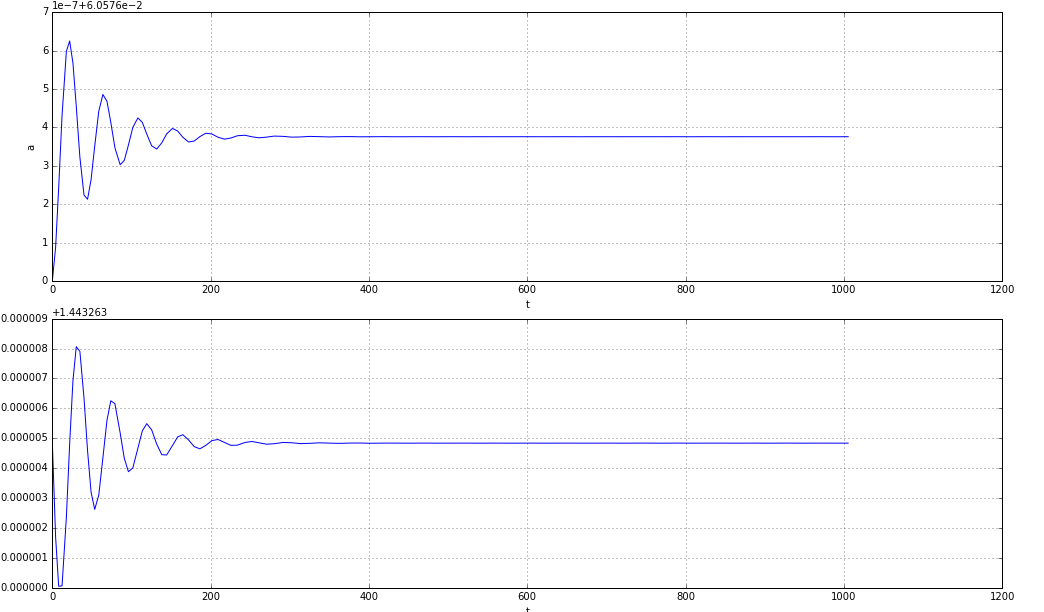

In [134]:
# unstable 2: delta: 1.000000, a: 0.060576, b: 1.443268
check_ab_stability(1.000000, 0.060576, 1.443268)


[= Runge Kutta 5 Adaptive ========================]
[=================================================]


<IPython.core.display.Javascript object>


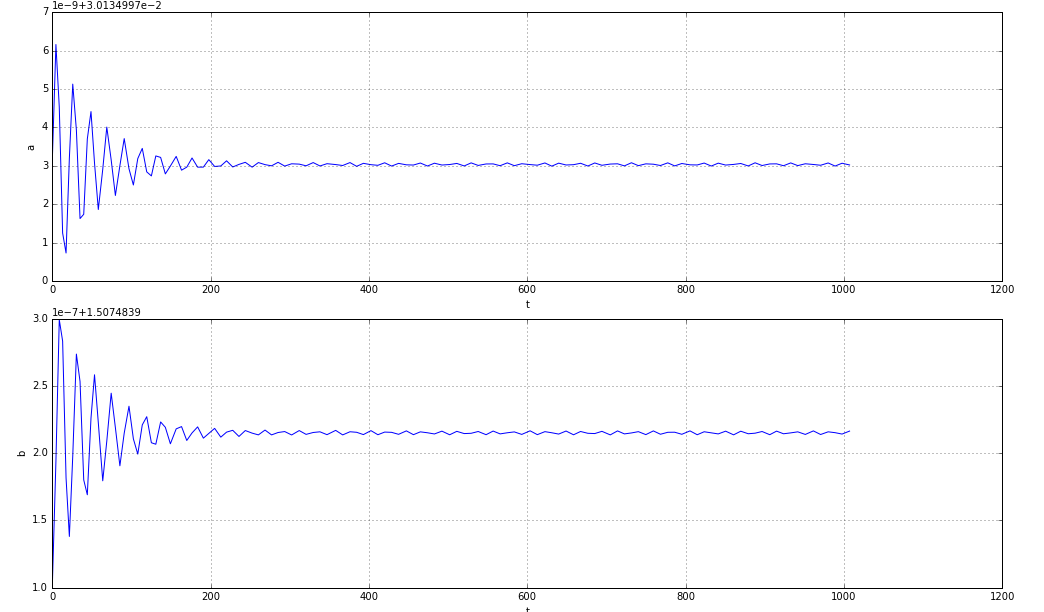

In [135]:
# unstable 3: delta: 2.000000, a: 0.030135, b: 1.507484
check_ab_stability(2.000000, 0.030135, 1.507484)

<IPython.core.display.Javascript object>


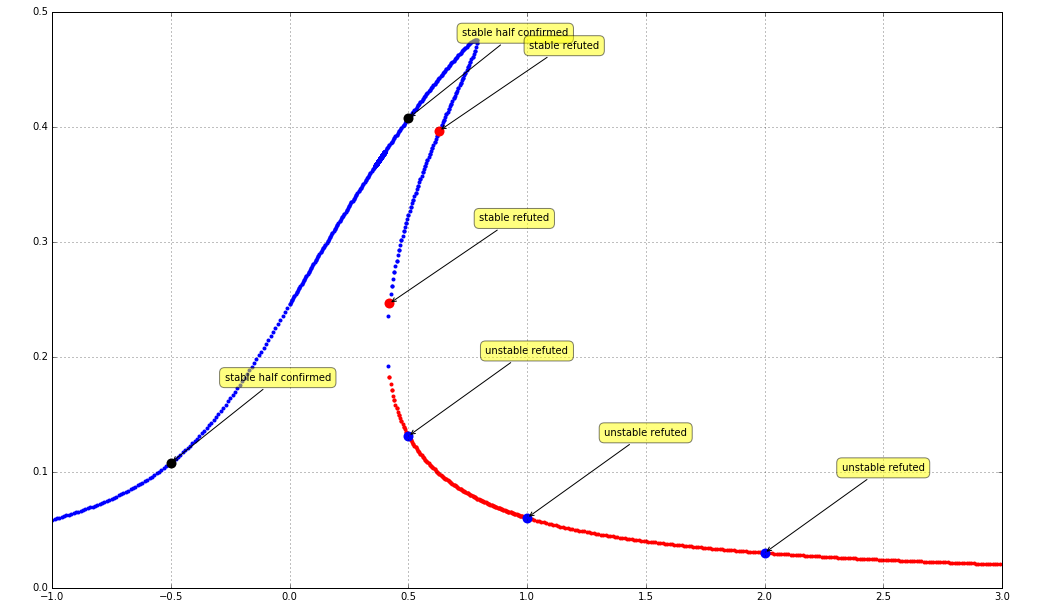

In [142]:
# display selected points

fig = create_fig()
plt.grid(b=True)

plt.plot(xs[STABLE], ys[STABLE], "bo", markeredgewidth=0.0, markersize=4)
plt.plot(xs[UNSTABLE], ys[UNSTABLE], "ro", markeredgewidth=0.0, markersize=4)
plt.plot(xs[UNKNOWN], ys[UNKNOWN], "go", markeredgewidth=0.0, markersize=4)

labels = [
 ["stable half confirmed" , -0.5, 0.108555, "ko"],
 ["stable half confirmed", 0.5, 0.407887, "ko"],
 ["stable refuted", 0.63,  0.397056, "ro"],
 ["stable refuted", 0.42, 0.246884, "ro"],
 ["unstable refuted", 0.5,  0.131723, "bo"],
 ["unstable refuted", 1.0,  0.060576, "bo"],
 ["unstable refuted", 2.0,  0.030135, "bo"]
]

for label, x, y, marker in labels:
    plt.annotate(
        label,
        xy=(x, y), xytext=(160, 80),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    plt.plot(x, y, marker, markeredgewidth=0.0, markersize=10)